<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [167]:
import matplotlib.pyplot as plt

%matplotlib inline

In [168]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

C:\Users\XianHui\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [169]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

# Concat features and target to Pandas DF to do EDA
boston_pdf = pd.concat([y, X], axis=1)
boston_pdf.head(10)

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,28.7,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,22.9,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,27.1,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,16.5,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,18.9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [170]:
# Check number of rows and columns
boston_pdf.shape
# 506 records, 14 (13 features + 1 target) columns

(506, 14)

In [171]:
# Check index
boston_pdf.index

RangeIndex(start=0, stop=506, step=1)

In [172]:
# Check column types
boston_pdf.dtypes

MEDV       float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [173]:
# Check for nulls
boston_pdf.isnull().sum()
# There is no null values.

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [174]:
# Get summary statistics
boston_pdf.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.197104,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [175]:
# Get count of unique values per column
boston_pdf.nunique()

MEDV       229
CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

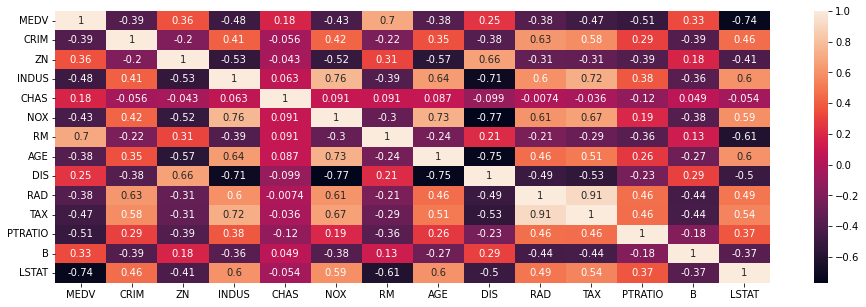

In [176]:
import seaborn as sns
# To adjust the size of heatmap
plt.figure(figsize=(16, 5))
sns.heatmap(boston_pdf.corr(), annot=True);

# Choose 4 features strongly correlated with MEDV and check for multicollinearlity:
# - LSTAT (-0.74)
# - RM (0.7)
# - PTRATIO (-0.51)
# - INDUS (-0.48) -> NOX, TAX and DIS are strongly correlated to INDUS but they are not 
#                    in the top 4 features so it is ok to retain INDUS.

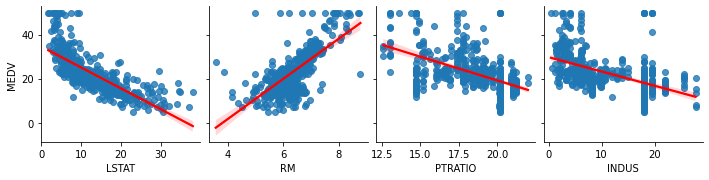

In [181]:
sns.pairplot(boston_pdf, x_vars=["LSTAT", "RM", "PTRATIO", "INDUS"], y_vars="MEDV", kind="reg", 
             plot_kws={"line_kws": {"color": "red"}});
# Observation:
# The value of MEDV is capped at around $50k.
# Each feature has a couple of outliers.
# LSTAT: The higher the percentage of lower status of the population, the lower the values of the houses. => negative correlation
# RM: The higher the number of rooms, the higher the values of the houses. => positive correlation
# PTRATIO: The higher the pupil-teacher ratio, the lower the values of the houses. => negative correlation
# INDUS: The higher the proportion of non-retail business acres, the lower the values of the houses. => negative correlation

In [182]:
from sklearn.linear_model import LinearRegression

# Create Linear Regression model with no train test split
lr = LinearRegression()
features = boston_pdf[["LSTAT", "RM", "PTRATIO", "INDUS"]]
target = boston_pdf["MEDV"]
lr.fit(features, target)
target_pred = lr.predict(features)
print(lr.intercept_)
print(lr.coef_)
# MEDV = 18.615 + -0.576 * LSTAT + 4.515 * RM + -0.935 * PTRATIO + 0.00757 * INDUS

18.6149704176851
[-0.57571066  4.51517866 -0.93512212  0.00756681]


In [183]:
# Pair the feature names with the coefficients.
list(zip(features, lr.coef_))

# Holding all other features fixed:
# - a 1-unit increase in lower status of the population is associated with a median value decrease of around $576.
# - a 1-unit increase in number of rooms is associated with a median value increase of around $4515.
# - a 1-unit increase in pupil-teacher ratio is associated with a median value decrease of around $935.
# - a 1-unit increase in non-retail business acres is associated with a median value increase of around $7.56.

[('LSTAT', -0.575710655265707),
 ('RM', 4.515178656314715),
 ('PTRATIO', -0.9351221174033515),
 ('INDUS', 0.0075668059009801674)]

In [184]:
lr.score(features, target)

0.6786434855761494

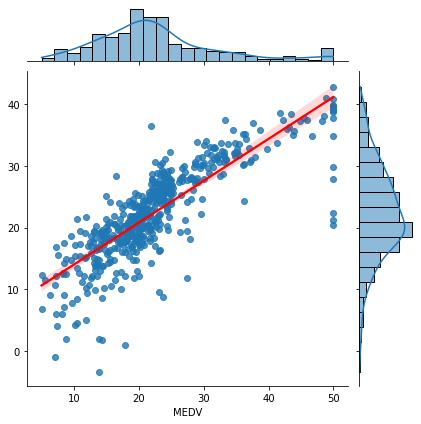

In [186]:
# Plot actual and predicted MEDV
sns.jointplot(x=target, y=target_pred, kind="reg", joint_kws={"line_kws": {"color": "red"}});
# Points are in a straight line but there are more points away from the straight line for lower MEDV.

In [187]:
from sklearn import metrics
print(f"MAE: {metrics.mean_absolute_error(target, target_pred)}")
print(f"MSE: {metrics.mean_squared_error(target, target_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(target, target_pred))}")

MAE: 3.6421818601490936
MSE: 27.128774315553887
RMSE: 5.208528997284539


### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [188]:
from sklearn.model_selection import train_test_split

# 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.7, random_state=123)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)
# Score drops

0.5551292687294014

In [189]:
y_pred = lr.predict(X_test)

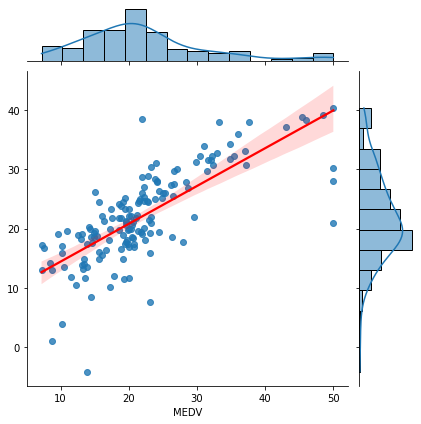

In [191]:
# Plot actual and predicted MEDV
sns.jointplot(x=y_test, y=y_pred, kind="reg", joint_kws={"line_kws": {"color": "red"}});
# Points are in a straight line but there are a couple of points away from the straight line.

In [192]:
from sklearn import metrics
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
# The RMSE is higher than our previous model => expected because previous
# model is trained and tested on the entire dataset (not out-of-
# sample data).

MAE: 4.2189358723231365
MSE: 35.95805224952432
RMSE: 5.996503335238322


In [193]:
from sklearn.model_selection import train_test_split

# 90/10 train/test split
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.9, random_state=123)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)
# Score drops

0.5400580055981409

In [194]:
y_pred = lr.predict(X_test)

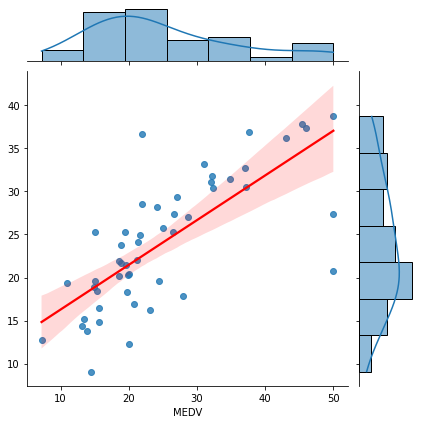

In [196]:
# Plot actual and predicted MEDV
sns.jointplot(x=y_test, y=y_pred, kind="reg", joint_kws={"line_kws": {"color": "red"}});
# Smaller testing size => more points away from line as compared to 70/30 train/test split.

In [197]:
from sklearn import metrics
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
# The RMSE is higher than the model with 70/30 train/test split
# => size of training/testing split is important as it affects the
#    the RMSE.

MAE: 4.8569809724814625
MSE: 52.58526194132443
RMSE: 7.251569619146219


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [198]:
from sklearn.model_selection import cross_val_score, cross_val_predict
scores_list = []
for folds in range(5, 11):
    lr = LinearRegression()
    scores = cross_val_score(lr, features, target, cv=folds)
    scores_list.append(scores)
    predictions = cross_val_predict(lr, features, target, cv=folds)
    rsquared = metrics.r2_score(target, predictions)
    
    print(f"Number of folds: {folds}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(target, predictions))}")
    print(f"R2: {rsquared}")
    print("---------------------------------")

Number of folds: 5
RMSE: 5.951849829631844
R2: 0.5803754721363648
---------------------------------
Number of folds: 6
RMSE: 5.989436044414842
R2: 0.5750588398762185
---------------------------------
Number of folds: 7
RMSE: 6.071611897326784
R2: 0.5633183505067769
---------------------------------
Number of folds: 8
RMSE: 5.728648701949999
R2: 0.6112581320654502
---------------------------------
Number of folds: 9
RMSE: 5.818190014012838
R2: 0.5990107437127719
---------------------------------
Number of folds: 10
RMSE: 5.808291067538384
R2: 0.6003740523956513
---------------------------------


In [199]:
# What seems optimal? How do your scores change?
# K = 8 is the most optimal - has the highest R2 value and lowest RMSE.
# The RMSE and R2 value are similar across 5 to 10 folds.

# What is the variance like? What are the tradeoffs associated with choosing the number of folds?
# The smaller the number of folds, the higher the bias and the lower the variance.

# KNN Practice

In [200]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [201]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [202]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [203]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris["species_num"] = iris["species"].map({"Iris-setosa":0, "Iris-versicolor":1, "Iris-virginica":2})
iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species,species_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


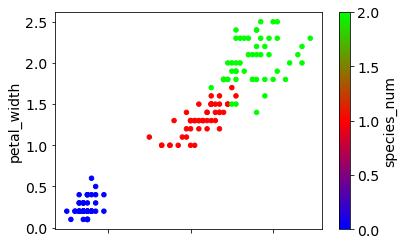

In [204]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind="scatter", x="petal_length", y="petal_width", c="species_num", colormap="brg");
# Iris-setosa has small petal width and petal length
# Iris-versicolor and iris-virginica have a slight overlapping of petal width and length
# but iris-virginica has the largest petal width and length compared to the other 2 species.

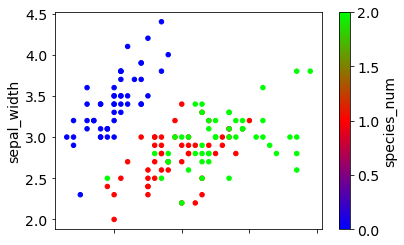

In [205]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
iris.plot(kind="scatter", x="sepal_length", y="sepal_width", c="species_num", colormap="brg");
# Iris-setosa has largest sepal width compared to the other 2 species
# but small sepal length
# Iris-versicolor and iris-virginica have similar sepal width and length
# but some iris-virginia flowers have longer sepal length as compared to iris-veriscolor

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [206]:
feature_cols = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
X = iris[feature_cols]

### Create your target vector "y"
This will be the species type.

In [207]:
y = iris["species_num"]

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [209]:
from sklearn.model_selection import train_test_split

# Use 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [210]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [211]:
y_pred = knn.predict(X_test)

from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.9111111111111111

### Create a Model With Five Neighbors. Did it Improve?

In [212]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
# Yes, the accuracy improved.

0.9777777777777777

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [213]:
training_error = []
testing_error = []
k_range = list(range(1, 101))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [214]:
column_dict = {"K": k_range, "training_error": training_error, "testing_error": testing_error}
df = pd.DataFrame(column_dict).set_index("K").sort_index(ascending=False)
df.head()

,training_error,testing_error
K,,
100,0.666667,0.777778
99,0.666667,0.777778
98,0.666667,0.777778
97,0.666667,0.777778
96,0.666667,0.777778


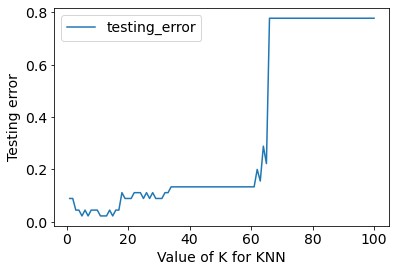

In [215]:
# Plot the relationship between K and testing error.
df.plot(y="testing_error");
plt.xlabel("Value of K for KNN");
plt.ylabel("Testing error");

In [217]:
min(list(zip(testing_error, k_range)))
# The best value for K is 5.

(0.022222222222222254, 5)

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [218]:
# It returns the probability estimates for the test data X. Each row sums to one and contains the probabilities of the point
# being a 0-Iris-setosa, 1-Iris-veriscolor, 2-Iris-virginica.

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [219]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [220]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX",
    "case4": "MEDV ~ LSTAT + RM + PTRATIO + INDUS"
}

model = smf.ols(formula=formulas['case4'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     264.5
Date:                Sun, 27 Nov 2022   Prob (F-statistic):          5.41e-122
Time:                        11:42:04   Log-Likelihood:                -1553.0
No. Observations:                 506   AIC:                             3116.
Df Residuals:                     501   BIC:                             3137.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.6150      3.927      4.741      0.000      10.900      26.330
LSTAT         -0.5757      0.048    -12.023      0.000      -0.670      -0.482
RM             4.5152      0.426     10.592      0.000       3.678       5.353
PTRATIO       -0.9351      0.120     -7.763      0.000      -1.172      -0.698
INDUS          0.0076      0.044      0.174      0.862      -0.078       0.093
==============================================================================
Omnibus:                      200.524   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1003.887
Skew:                           1.689   Prob(JB):                    1.02e-218
Kurtosis:                       9.017   Cond. No.                         452.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

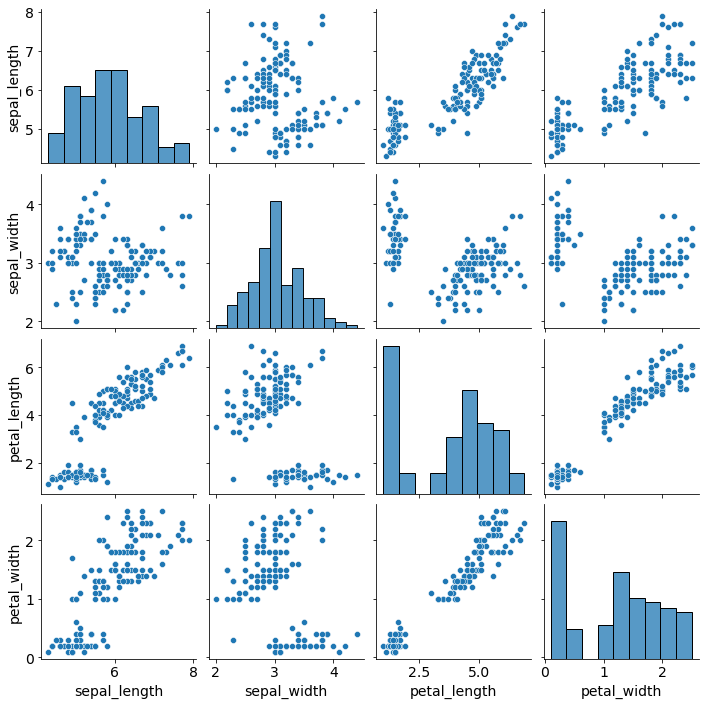

In [95]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [96]:
# Check out Pearson scores


## Demo: Patsy

In [97]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [98]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [99]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.13003892778354043
